In [3]:
import pandas as pd
import mysql.connector
import os

# List of CSV files and their corresponding table names
csv_files = [
    ('customers.csv', 'customers'),
    ('orders.csv', 'orders'),
    ('sellers.csv', 'sellers'),
    ('products.csv', 'products'),
    ('order_items.csv', 'order_items'),
    ('payments.csv', 'payments'),
    ('geolocation.csv','geolocation')# Added payments.csv for specific handling
]

# Connect to the MySQL database
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='1234567890',
    database='ecommerce'
)
cursor = conn.cursor()

# Folder containing the CSV files
folder_path = 'C:/Users/HP/OneDrive/Desktop/ecommerce'

def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)
    
    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection
conn.close()

Processing customers.csv
NaN values before replacement:
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

Processing orders.csv
NaN values before replacement:
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

Processing sellers.csv
NaN values before replacement:
seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
dtype: int64

Processing products.csv
NaN values before replacement:
product_id                      0
product category              610
product_name_length           610
product_description_length    610
product_photos_qty            610
prod

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector

db = mysql.connector.connect(
    host = 'localhost',
    username = 'root',
    password = '1234567890',
    database = 'ecommerce'
)
cur = db.cursor()

# List all unique cities where customers are located.

In [87]:
query = """ select distinct(customer_city) from ecommerce.customers """

cur.execute(query)
data = cur.fetchall()
data

df = pd.DataFrame(data, columns =["Unique city List"])
df.head(20)

,Unique city List
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas
5,jaragua do sul
6,timoteo
7,curitiba
8,belo horizonte
9,montes claros


# Count the number of orders placed in 2017.

In [12]:
query = """ select count( order_id) from ecommerce.orders where order_purchase_timestamp like "2017%" """

cur.execute(query)

data = cur.fetchall()

data[0][0]

90202

# Find the total number of sales per category.

In [20]:
import pandas as pd
query = """ select distinct( product_category ), count(order_id) from ecommerce.order_items 
join ecommerce.products 
on order_items.product_id = products.product_id
group by product_category; """

cur.execute(query)
data = cur.fetchall()
data
df = pd.DataFrame(data, columns =["category","no of orders"])
df

,category,no of orders
0,HEALTH BEAUTY,38680
1,sport leisure,34564
2,Cool Stuff,15184
3,computer accessories,31308
4,Watches present,23964
...,...,...
69,flowers,132
70,Kitchen portable and food coach,60
71,CITTE AND UPHACK FURNITURE,152
72,House Comfort 2,120


# Find the total sells per cateogory

In [24]:
query = """ select distinct( products.product_category ), round(sum(payments.payment_value),2)  from ecommerce.order_items 
join ecommerce.products 
on order_items.product_id = products.product_id
join payments
on order_items.order_id = payments.order_id
group by product_category;"""

cur.execute(query)
data = cur.fetchall()
data
df = pd.DataFrame(data, columns=["Category","Sells"])
df

,Category,Sells
0,perfumery,4053909.28
1,Furniture Decoration,11441411.13
2,telephony,3895056.41
3,bed table bath,13700429.37
4,automotive,6818354.65
...,...,...
69,cds music dvds,9595.44
70,La Cuisine,23308.24
71,Fashion Children's Clothing,6285.36
72,PC Gamer,17395.44


# Calculate the percentage of orders that were paid in installments.

In [27]:
query = """ select (sum(case when payment_installments >1 then 1 else 0 end))/ count(*)*100 from ecommerce.payments """
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns=["installments payments"])
df 

,installments payments
0,49.4176


# Count the number of customers from each state.

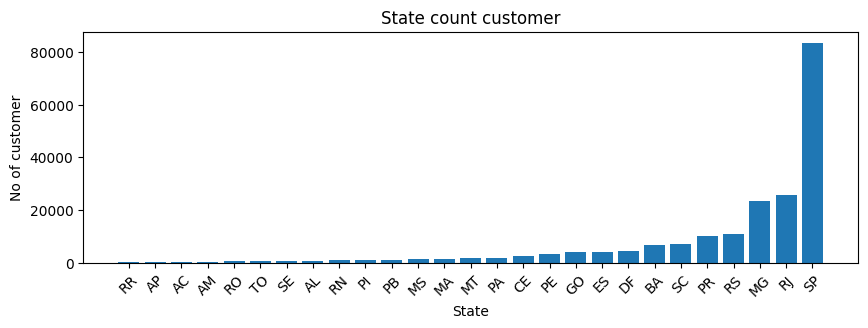

In [76]:
import matplotlib.pyplot as plt
query = """ select distinct(customer_state), count(customer_id) from ecommerce.customers
group by customer_state"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns =["State","No of Customers"])
df = df.sort_values(by = "No of Customers",ascending = True)
df
plt.figure(figsize=(10,3))
plt.bar(df["State"],df["No of Customers"])
plt.xticks(rotation = 45)
plt.xlabel("State")
plt.ylabel("No of customer")
plt.title("State count customer")
plt.show()

# Calculate the number of orders per month in 2018.

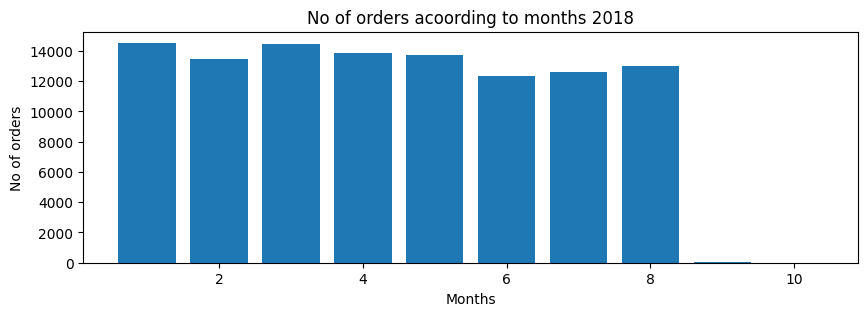

In [78]:
query = """ select month(order_purchase_timestamp) months, count(orders.customer_id) orders from orders
where year(order_purchase_timestamp) = 2018
group by months
order by months asc; """

cur.execute(query)
data = cur.fetchall()
data
df = pd.DataFrame(data, columns =["Months","No of orfers"])

plt.figure(figsize=(10,3))
plt.bar(df['Months'],df['No of orfers'])
plt.xlabel("Months")
plt.ylabel("No of orders")
plt.title("No of orders acoording to months 2018")
plt.show()

# Find the average number of products per order, grouped by customer city.

In [80]:
query = """ with count_per_order as
(select orders.order_id, orders.customer_id, count(order_items.order_id) as order_count from orders
join order_items
on orders.order_id = order_items.order_id
group by orders.order_id, orders.customer_id)

select customers.customer_city, round(avg(count_per_order.order_count),2) as avg_order from customers
join count_per_order 
on customers.customer_id = count_per_order.customer_id
group by customers.customer_city; """

cur.execute(query)
data = cur.fetchall()
data

df = pd.DataFrame(data, columns = ["Customer City", "Avg Order"])
df

,Customer City,Avg Order
0,sao paulo,4.62
1,sao jose dos campos,4.55
2,porto alegre,4.70
3,indaial,4.46
4,treze tilias,5.09
...,...,...
4105,sambaiba,4.00
4106,guairaca,8.00
4107,japaratuba,4.00
4108,tuiuti,4.00


#  Calculate the percentage of total revenue contributed by each product category.

In [82]:
query = """ select distinct( products.product_category ), round((sum(payments.payment_value)/(select sum(payments.payment_value) from payments))*100,2) as Revenue_Percentage  from ecommerce.order_items 
join ecommerce.products 
on order_items.product_id = products.product_id
join payments
on order_items.order_id = payments.order_id
group by product_category; """

cur.execute(query)
data = cur.fetchall()
data

df = pd.DataFrame(data, columns =["Product Category", "Revenue"])
df

,Product Category,Revenue
0,perfumery,12.66
1,Furniture Decoration,35.73
2,telephony,12.17
3,bed table bath,42.79
4,automotive,21.30
...,...,...
69,cds music dvds,0.03
70,La Cuisine,0.07
71,Fashion Children's Clothing,0.02
72,PC Gamer,0.05


# Identify the correlation between product price and the number of times a product has been purchased.

In [91]:
import numpy as np
query = """ select distinct(product_id), count(order_items.order_id), order_items.price from order_items
group by product_id,order_items.price; """

cur.execute(query)
data = cur.fetchall()

df = pd.DataFrame(data, columns= ["Product_ID","No_of_Order","Product_Price"])
arr1 = df["No_of_Order"];
arr2 = df["Product_Price"];

print("Sells are normal not varry on price");
np.corrcoef([arr1,arr2])

Sells are normal not varry on price


array([[ 1.        , -0.04421869],
       [-0.04421869,  1.        ]])

# Calculate the total revenue generated by each seller, and rank them by revenue.

In [96]:
query = """ select *,dense_rank() over(order by total_revenue desc) as ranking from(select distinct(order_items.seller_id), round(sum(payments.payment_value),2) as total_revenue  
from order_items 
join payments
on order_items.order_id = payments.order_id
group by order_items.seller_id) as tab1; """

cur.execute(query)
data = cur.fetchall()
data

df = pd.DataFrame(data, columns = ["Seller_id","Total_Revenue","Order_Rank"])
df

,Seller_id,Total_Revenue,Order_Rank
0,7c67e1448b00f6e969d365cea6b010ab,2028667.63,1
1,1025f0e2d44d7041d6cf58b6550e0bfa,1232888.16,2
2,4a3ca9315b744ce9f8e9374361493884,1204981.08,3
3,1f50f920176fa81dab994f9023523100,1161013.68,4
4,53243585a1d6dc2643021fd1853d8905,1139612.32,5
...,...,...,...
3090,ad14615bdd492b01b0d97922e87cb87f,76.84,3076
3091,702835e4b785b67a084280efca355756,74.24,3077
3092,4965a7002cca77301c82d3f91b82e1a9,65.44,3078
3093,77128dec4bec4878c37ab7d6169d6f26,60.88,3079


# Calculate the moving average of order values for each customer over their order history.

In [102]:
query = """ select *, avg(payment) over(partition by customer_id order by orders.order_purchase_timestamp 
rows between 2 preceding and current row ) from 
(select orders.customer_id, orders.order_purchase_timestamp, payments.payment_value as payment
from orders join payments
on orders.order_id = payments.order_id) as tab1; """

cur.execute(query)
data = cur.fetchall()
data
df = pd.DataFrame(data, columns =["Customer Id","Purched Time","Payment Value","Moving Average"])
df

,Customer Id,Purched Time,Payment Value,Moving Average
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
2,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
3,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
4,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
...,...,...,...,...
415539,ffffa3172527f765de70084a7e53aae8,2017-09-02 11:53:32,45.50,45.500000
415540,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001
415541,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001
415542,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001


# Calculate the cumulative sales per month for each year.

In [105]:
query = """ select years, months, round(sales,2), round(sum(sales) over(order by years,months),2) as cumulative_sales from 
(select year(order_purchase_timestamp) as years, month(order_purchase_timestamp)as months, sum(payments.payment_value) as sales
from orders join payments
on orders.order_id = payments.order_id
group by years,months
order by years,months) as tab1; """

cur.execute(query)
data = cur.fetchall()
data
df = pd.DataFrame(data, columns= ["Years","Months","Sales","Cumulative Sales"])
df

,Years,Months,Sales,Cumulative Sales
0,2016,9,1008.96,1008.96
1,2016,10,236361.92,237370.88
2,2016,12,78.48,237449.36
3,2017,1,553952.16,791401.52
4,2017,2,1167632.04,1959033.56
5,2017,3,1799454.40,3758487.96
6,2017,4,1671152.12,5429640.07
7,2017,5,2371675.28,7801315.35
8,2017,6,2045105.52,9846420.88
9,2017,7,2369531.68,12215952.55


# Calculate the year-over-year growth rate of total sales.

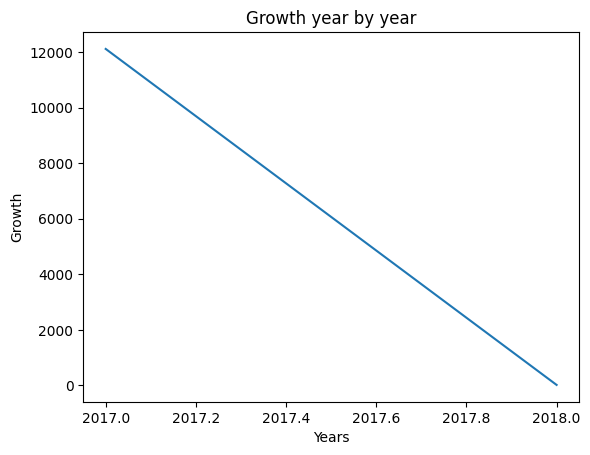

In [118]:
query = """select *, round((sales-lag(sales,1) over(order by years asc))/lag(sales,1) over(order by years asc) *100,2) as percentage from
(select year(order_purchase_timestamp) as years, round(sum(payments.payment_value)) as sales from orders
join payments
on orders.order_id = payments.order_id
group by years
order by years) as tab1;"""

cur.execute(query)
data = cur.fetchall()
data 
df =pd.DataFrame(data, columns = ["Year","Sales","Growth"])
df

plt.figure()
plt.plot(df['Year'],df['Growth'])
plt.xlabel("Years")
plt.ylabel("Growth")
plt.title("Growth year by year")
plt.show()

# Identify the top 3 customers who spent the most money in each year.

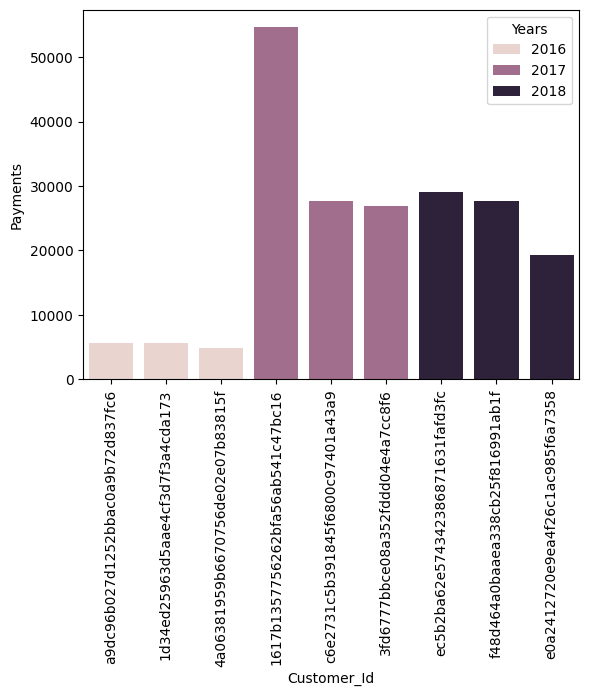

In [124]:
query = """ select years, customer_id,total_sales,d_rank from 
(select year(orders.order_purchase_timestamp) as years, orders.customer_id , round(sum(payments.payment_value),2) as total_sales, 
dense_rank() over(partition by year(orders.order_purchase_timestamp) order by round(sum(payments.payment_value),2) desc) as D_rank from orders
join payments
on payments.order_id = orders.order_id
group by year(orders.order_purchase_timestamp),orders.customer_id) as tab1
where d_rank <=3; """

cur.execute(query)
data = cur.fetchall()
data

df = pd.DataFrame(data, columns=["Years","Customer_Id","Payments","Rank"])
df
sns.barplot(x="Customer_Id",y="Payments", data = df , hue ="Years")
plt.xticks(rotation = 90)
plt.show()